In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt
import seaborn as sns
from scipy.stats import wilcoxon, friedmanchisquare

In [2]:
# Dataset load, info and data summary
df = pd.read_csv('../data/AIRPOL_data.csv', delimiter=";", header=0, usecols=[*range(0,8)], decimal=',')
df = df[df['NUTS_Code'].str.match(r'^[A-Z]{2}[A-Za-z0-9]{3}$')]
df.drop_duplicates

<bound method DataFrame.drop_duplicates of        Country NUTS_Code Air_Pollutant Outcome  Affected_Population  \
10     Albania     AL011           NO2  Asthma             114946.0   
11     Albania     AL021         PM2.5  Asthma              48563.0   
12     Albania     AL031           NO2  Asthma             119255.0   
13     Albania     AL011         PM2.5  Asthma              22427.0   
14     Albania     AL013           NO2  Asthma              71521.0   
...        ...       ...           ...     ...                  ...   
49135   Turkey     TR822           NO2  Stroke             213615.0   
49136   Turkey     TRB12           NO2  Stroke             447268.0   
49137   Turkey     TRB14           NO2  Stroke              76591.0   
49138   Turkey     TRB21           NO2  Stroke             696344.0   
49139   Turkey     TRB22           NO2  Stroke             362047.0   

       Populated_Area[km2]  Air_Pollution_Average[ug/m3]  Value  
10                  1014.3            

In [3]:
southern_europe = ["Spain", "Portugal", "Italy", "Greece"]
df_se = df[df['Country'].isin(southern_europe)].copy()

In [4]:
df_se.rename(columns={'Value': 'Premature_Deaths'}, inplace=True)
numeric_cols = ['Affected_Population', 'Populated_Area[km2]', 'Air_Pollution_Average[ug/m3]', 'Premature_Deaths']
correlation = df_se[numeric_cols].corr()['Premature_Deaths'].drop('Premature_Deaths')

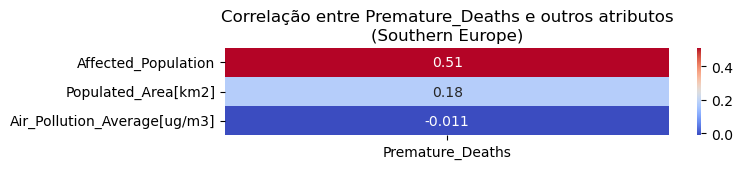

In [5]:
plt.figure(figsize=(8, len(correlation) * 0.6))
sns.heatmap(correlation.to_frame(), annot=True, cmap='coolwarm', cbar=True)
plt.title('Correlação entre Premature_Deaths e outros atributos\n(Southern Europe)')
plt.tight_layout()
plt.show()

# Alinea 2

In [6]:


X = df_se[['Affected_Population']].values  # Variável independente (X)
y = df_se['Premature_Deaths'].values       # Variável dependente (y)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

maes = []
rmses = []
coefs = []
intercepts = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    maes.append(mean_absolute_error(y_test, y_pred))
    rmses.append(sqrt(mean_squared_error(y_test, y_pred)))
    coefs.append(model.coef_[0])
    intercepts.append(model.intercept_)

avg_coef = np.mean(coefs)
avg_intercept = np.mean(intercepts)
avg_mae = np.mean(maes)
avg_rmse = np.mean(rmses)



## Alinea a

In [7]:
# 10. a) Exibe a função linear média
print(f"Função linear média: Premature_Deaths = {avg_coef:.4f} * Affected_Population + {avg_intercept:.4f}")

Função linear média: Premature_Deaths = 0.0004 * Affected_Population + -7.2988


## Alinea b

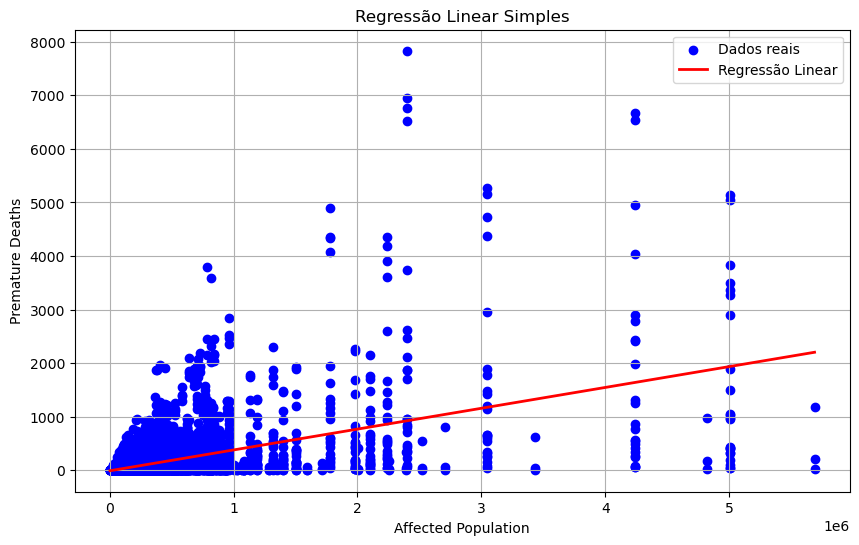

In [8]:
# 11. b) Gráfico da regressão linear e dispersão
plt.figure(figsize=(10, 6))
plt.scatter(X, y, color='blue', label='Dados reais')
x_line = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
y_line = avg_coef * x_line + avg_intercept
plt.plot(x_line, y_line, color='red', linewidth=2, label='Regressão Linear')
plt.xlabel('Affected Population')
plt.ylabel('Premature Deaths')
plt.title('Regressão Linear Simples')
plt.legend()
plt.grid(True)
plt.show()

## Alinea c

In [9]:

# 12. c) Exibe as métricas de erro
print(f"Erro Médio Absoluto (MAE): {avg_mae:.2f}")
print(f"Raiz Quadrada do Erro Médio (RMSE): {avg_rmse:.2f}")

Erro Médio Absoluto (MAE): 145.17
Raiz Quadrada do Erro Médio (RMSE): 364.45


# Exercicio 2

In [10]:
# 2. Seleção de variáveis preditoras para regressão múltipla
features = ['Affected_Population', 'Populated_Area[km2]', 'Air_Pollution_Average[ug/m3]']
X = df_se[features].values
y = df_se['Premature_Deaths'].values

kf = KFold(n_splits=5, shuffle=True, random_state=42)


In [11]:
# --- a) Regressão Linear Múltipla com K-Fold ---

maes_lr = []
rmses_lr = []

for train_idx, test_idx in kf.split(X):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    lr = LinearRegression()
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)

    maes_lr.append(mean_absolute_error(y_test, y_pred))
    rmses_lr.append(np.sqrt(mean_squared_error(y_test, y_pred)))

print("Regressão Linear Múltipla")
print(f"MAE médio: {np.mean(maes_lr):.2f}")
print(f"RMSE médio: {np.mean(rmses_lr):.2f}")

Regressão Linear Múltipla
MAE médio: 145.47
RMSE médio: 364.18



Árvore de Regressão
Melhores parâmetros: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5}
MAE médio: 133.49
RMSE médio: 343.79


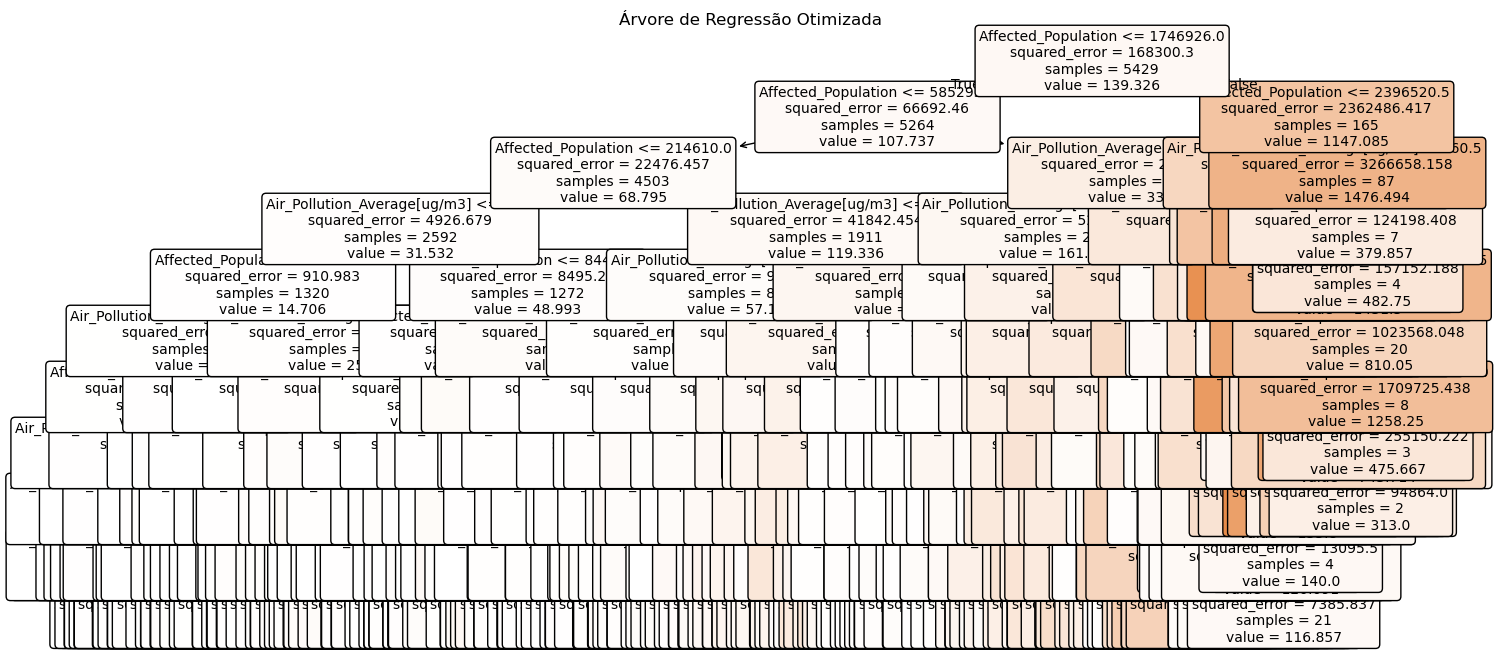

In [12]:
# --- b) Árvore de Regressão com otimização de parâmetros ---

param_grid = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

dt = DecisionTreeRegressor(random_state=42)
grid_search = GridSearchCV(dt, param_grid, cv=kf, scoring='neg_mean_squared_error')
grid_search.fit(X, y)

best_dt = grid_search.best_estimator_

print("\nÁrvore de Regressão")
print(f"Melhores parâmetros: {grid_search.best_params_}")

# Avaliação da melhor árvore com K-Fold
maes_dt = []
rmses_dt = []
for train_idx, test_idx in kf.split(X):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    best_dt.fit(X_train, y_train)
    y_pred = best_dt.predict(X_test)

    maes_dt.append(mean_absolute_error(y_test, y_pred))
    rmses_dt.append(np.sqrt(mean_squared_error(y_test, y_pred)))

print(f"MAE médio: {np.mean(maes_dt):.2f}")
print(f"RMSE médio: {np.mean(rmses_dt):.2f}")

# Visualizar a árvore
plt.figure(figsize=(16,8))
plot_tree(best_dt, feature_names=features, filled=True, rounded=True, fontsize=10)
plt.title("Árvore de Regressão Otimizada")
plt.show()

In [13]:
# --- d) Rede Neural com otimização da configuração ---

param_grid_mlp = {
    'hidden_layer_sizes': [(50,), (100,), (50,50)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam'],
    'alpha': [0.0001, 0.001],
    'max_iter': [500]
}

mlp = MLPRegressor(random_state=42)
grid_search_mlp = GridSearchCV(mlp, param_grid_mlp, cv=kf, scoring='neg_mean_squared_error', refit=True)
grid_search_mlp.fit(X, y)

best_mlp = grid_search_mlp.best_estimator_

print("\nRede Neural")
print(f"Melhores parâmetros: {grid_search_mlp.best_params_}")
maes_mlp = []
rmses_mlp = []
for train_idx, test_idx in kf.split(X):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    best_mlp.fit(X_train, y_train)
    y_pred = best_mlp.predict(X_test)

    maes_mlp.append(mean_absolute_error(y_test, y_pred))
    rmses_mlp.append(np.sqrt(mean_squared_error(y_test, y_pred)))

print(f"MAE médio: {np.mean(maes_mlp):.2f}")
print(f"RMSE médio: {np.mean(rmses_mlp):.2f}")


Rede Neural
Melhores parâmetros: {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (50,), 'max_iter': 500, 'solver': 'adam'}
MAE médio: 149.81
RMSE médio: 374.38
